# Pratical Complexity of our Key Exposure Attacks on Rainbow

## Pratical complexity  error model

Complexity of ISD algorithms over Fq. Parts of the code in this section are taken from the Syndrome Decoding Estimator repository by A. Esser and E. Bellini  
 https://github.com/Crypto-TII/syndrome_decoding_estimator  

In [4]:
### Complexity of ISD algorithms over Fq
from math import inf,log2
from math import comb as binom

def _mem_matrix(n, k,r):
    """
    Memory usage of parity check matrix in vector space elements

    INPUT:

    - ``n`` -- length of the code
    - ``k`` -- dimension of the code
    - ``r`` -- block size of M4RI procedure 

    """
    return n - k + 2**r



def _list_merge(L1, l, q, hmap=1):
    """
    Complexity estimate of merging two lists ``L1`` and ``L2`` on l bits

    INPUT:

    - ``L1`` -- size of first list
    - ``L2`` -- size of second list
    - ``l`` -- amount of bits used for matching
    - ``hmap`` -- indicates if hashmap is being used (Default 0: no hashmap)
    """

    if L1 == 1:
        return 1
    if not hmap:
        return max(1, 2 * log2(L1) * L1 + L1 ** 2 / q ** l)
    else:
        return 2 * L1 + L1 ** 2 / q ** l



#field multiplications needed for Gaussian elimination inside of ISD
def _gaussian_elimination(n,k,q,r):
    return n*(n-k)^2

#Complexity of Prange's algorithm for syndrome decoding over Fq in field multiplications
def q_ary_prange(n, k, w, q, mem=inf,minrank=1):
    """
    Complexity estimate of Prange's ISD algorithm

    [Pra62] Prange, E.: The use of information sets in decoding cyclic codes. IRE Transactions
                        on Information Theory 8(5), 5–9 (1962)

    expected weight distribution
    +--------------------------------+-------------------------------+
    | <----------+ n - k +---------> | <----------+ k +------------> |
    |                w               |              p                |
    +--------------------------------+-------------------------------+
    """
    time = inf
    memory = 0
    params=[-1,-1]
    r=0
    tests=max(0, log2(binom(n, w)) + log2((q - 1) ** w) - log2(q ** (n - k)))+log2(_gaussian_elimination(minrank,0,q,r))
    for p in range(max(0, w - (n - k)), min(w, k) + 1):
        
        tmp_time = log2(binom(n, w)) - log2(binom(n - k, w - p)) + log2((q - 1) ** p)
        tmp_time += log2(_gaussian_elimination(n, k, q, r))
        tmp_time = max(tests,tmp_time)

        if tmp_time < time:
            time = tmp_time
            params = [p, r]

    res = {"time": time, "memory": memory, "p": params[0], "r": params[1],"sols":max(0, log2(binom(n, w)) + log2((q - 1) ** w) - log2(q ** (n - k))),"tests":tests}    
    return res

#Complexity of Dumer's algorithm for syndrome decoding over Fq in field multiplications
def q_ary_dumer(n, k, w, q, mem=inf, hmap=1,minrank=1,error_prob=0):
    """
    Complexity estimate of Stern's ISD algorithm

    [Dum91] Dumer, I.:  On minimum distance decoding of linear codes. In: Proc. 5th Joint
                        Soviet-Swedish Int. Workshop Inform. Theory. pp. 50–52 (1991)

    expected weight distribution:
                +--------------------------+------------------+-------------------+
                | <-----+ n - k - l +----->|<-- (k + l)/2 +-->|<--+ (k + l)/2 +-->|
                |           w - 2*p        |       p          |        p          |
                +--------------------------+------------------+-------------------+
    """
    time = inf
    memory = 0
    params=[-1 for _ in range(10)]
    solutions = 0#max(0, log2(binom(n, w)) + log2((q - 1) ** w) - log2(q ** (n - k)))
    solutions1=max(0, log2(binom(n, w)) + log2((q - 1) ** w) - log2(q ** (n - k)))
    r=0
    tests=max(0, log2(binom(n, w)) + log2((q - 1) ** w) - log2(q ** (n - k)))+log2(_gaussian_elimination(minrank,0,q,r))
    for l in range(n - k):
        k1 = int(ceil((k + l) /2))
        for p in range(max(0, int((w - (n - k - l) + 1) / 2)), int(min(w, k) / 2) + 1, 1):
            L = binom(k1, p) * (q - 1) ** p
            if error_prob!=0:
                values=sum(binom(int(log2(q)),i) for i in range(int(ceil(log2(q)*error_prob))+1))
                L=binom(k1, p) * values**p
            if log2(L)>time:
                continue
            
            Tp = log2(binom(n, w)) - log2(binom(n - k - l, w - 2 * p)) - 2 * log2(binom(k1, p)) - solutions
            tmp_time = Tp + log2(_gaussian_elimination(n, k, q, r) + max(n*_list_merge(L, l, q, hmap),0))
            tmp_time = max(tmp_time,tests)
            if tmp_time < time:
                time = tmp_time
                params = [l, p, r,log2(max(_list_merge(L, l, q, hmap),solutions1-Tp)),log2(L)]
    res = {"time": time, "memory": memory, "l": params[0], "p": params[1], "r": params[2],"tests" :tests}
    return res

#bit to field error translation
def error_weight(n,q,p):
    return int(ceil((1 - (1 - p) ^ (log2(q)) )*n))

In [11]:
#Rainbow parameters
rainbow1={"n" :  68, "n_k" : 36, "q" : 16, "best":143, "minrank" : 100, "col_len" : 4*32, "v":36,"o2":32}
rainbow3={"n" : 116, "n_k" : 68, "q" : 256, "best":213, "minrank" : 148, "col_len" : 8*48, "v":68,"o2":48}
rainbow5={"n" : 160, "n_k" : 96, "q" : 256, "best":272, "minrank" : 196, "col_len" : 8*64, "v":96,"o2":64}

In [8]:
#compute complexities of partial key exposure attack using Prange, Dumer and Bruteforce
def show_rainbow(n,n_k,q,best_attack,minrank,col_len,v,o2,stepsize=50,pmax=0.5):
    L_rainbow_prange=[]
    L_rainbow_dumer=[]
    L_rainbow_brute=[]

    startn=n
    startn_k=n_k
    startk=n-n_k
    p=0.0001
    p_bound=pmax
    while p<=p_bound:
        pra=inf 
        dum=inf 
        
        #bruteforce best choice for r 
        for r in [i for i in range(1,v*(v-1)//2,stepsize)]+[v*(v-1)//2]:#[i for i in range(7,v*(v-1)//2,500)]+[v,v*(v-1)//2]:#
            
            n_k=r
            n=r+o2
            k=n-n_k
            w=error_weight(n,q,p)
            
            tmp1=q_ary_prange(n,k,w,q,minrank=minrank)
            tmp1["time"]+=log2(log2(q))*2
            if tmp1["time"]<pra:
                pra=tmp1['time']

            tmp2=q_ary_dumer(n,k,w,q,minrank=minrank)
            tmp2["time"]+=log2(log2(q))*2
            if tmp2["time"]<dum:
                dum=tmp2["time"]
        
        if dum !=inf:
                L_rainbow_dumer.append([p,dum])
        if pra !=inf:
            L_rainbow_prange.append([p,pra])
            
        L_rainbow_brute.append([p,log2(binom(col_len,int(ceil(p*col_len))))+log2(_gaussian_elimination(minrank,0,q,0))+log2(log2(q))*2])
        p+=0.01

    Dum=list_plot(L_rainbow_dumer,color="purple",legend_label="Dumer")
    Dum.set_legend_options(font_size=15, markerscale=2,labelspacing=0.5)
    
    Pra=list_plot(L_rainbow_prange,color="blue",legend_label="Prange")
    Pra.set_legend_options(font_size=15, markerscale=2)
    
    Best=line(([0.01,best_attack],[p_bound,best_attack]),color="orange",legend_label="security level")
    Best.set_legend_options(font_size=15, markerscale=2)
    
    Bru=list_plot(L_rainbow_brute,color="pink",legend_label="brute force")
    Bru.set_legend_options(font_size=15, markerscale=2)
    
    show(Best+Pra+Dum+Bru,figsize=10)
    return L_rainbow_brute,L_rainbow_prange,L_rainbow_dumer

In [9]:
#Select rainbow parameter set 
r=rainbow1
#r=rainbow3
#r=rainbow5

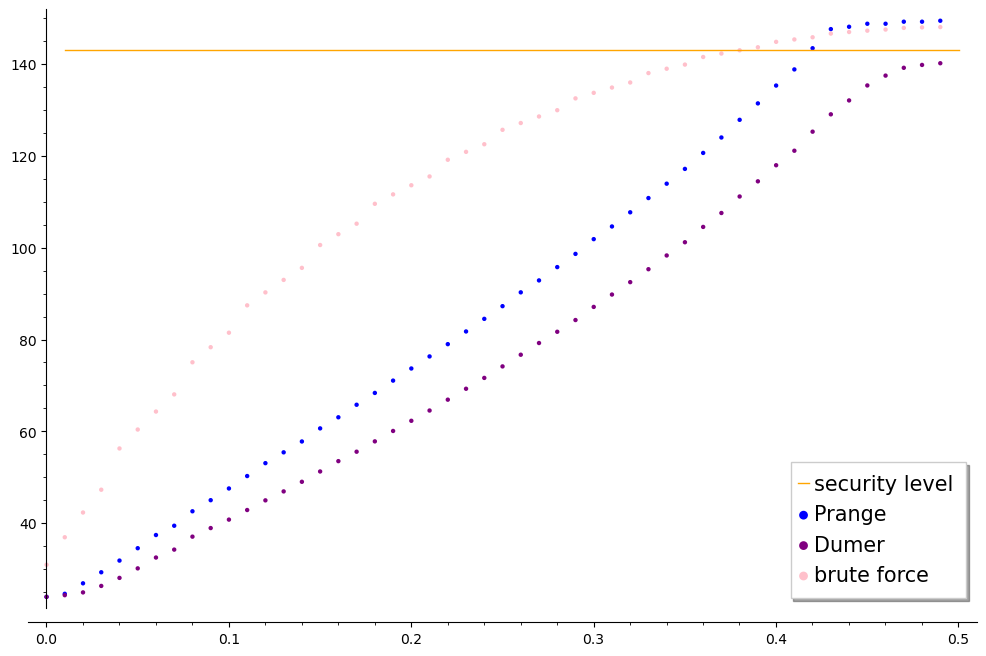

In [10]:
#calculates bit complexities of bruteforce, Prange and Dumer
#computation for parameter sets 3 and 5 might take some time, you might want to increase the stepsize 
#and / or lower the maximum error probability considered (pmax)
Lbrute,Lprange,Ldumer=show_rainbow(r["n"],r["n_k"],r["q"],r["best"],r["minrank"],r["col_len"],r["v"],r["o2"],stepsize=50,pmax=0.5001)

# Rainbow

### Key generation

In [26]:
#Building Symmetric Matrix

def get_indexes(mono, n):
    indexes = []
    vec = mono.degrees()
    for pos in range(n):
        if vec[pos] == 2:
            return pos, pos
        if vec[pos] == 1:
            indexes.append(pos)
    return indexes[0], indexes[1]

#
def get_symmetric_matrix_of_quadratic_part(f):
    n = f.parent().ngens()
    F = f.base_ring()
    M_f = zero_matrix(F, n, n)
    if F.characteristic() == 2:
        for mono in f.monomials():
            if mono.degree() == 2:
                 i1, i2 = get_indexes(mono, n)
#                if i1 == i2:
#                    M_f.add_to_entry(i1, i1, f.coefficient(mono))
#                else:
                 M_f.add_to_entry(i1, i2, f.coefficient(mono))
                 M_f.add_to_entry(i2, i1, f.coefficient(mono))
    else:
        for mono in f.monomials():
            if mono.degree() == 2:
                i1, i2 = get_indexes(mono, n)
                if i1 == i2:
                    M_f.add_to_entry(i1, i1, f.coefficient(mono))
                else:
                    M_f.add_to_entry(i1, i2, f.coefficient(mono) / 2)
                    M_f.add_to_entry(i2, i1, f.coefficient(mono) / 2)
    return M_f



In [27]:
#Innner map T generation
def get_random_inner_map(q,v,o1,o2):
    """
    Return the matrix representing the inner hidden map T
    """
    F = GF(q)
    T1 = random_matrix(F, v, o1)
    T2 = random_matrix(F, v, o2)
    T3 = random_matrix(F, o1, o2)
    Iv1 = identity_matrix(F, v)
    Io1 = identity_matrix(F, o1)
    Io2 = identity_matrix(F, o2)
    T = block_matrix([[Iv1, T1, T2], [zero_matrix(F, o1, v), Io1, T3], [zero_matrix(F, o2, v), zero_matrix(F, o2, o1), Io2]]) 
    return T

#Outer map S generation
def get_random_outer_map(q, o1,o2):
    """
    Return the matrix representing the inner hidden map S
    """
    F = GF(q)
    S_prime = random_matrix(F, o1, o2) 
    Io1 = identity_matrix(F, o1)
    Io2 = identity_matrix(F, o2)
    return block_matrix([[Io1, S_prime], [zero_matrix(F, o2, o1), Io2]]) 




In [28]:
T = get_random_inner_map(q=4,v=5,o1=5,o2=5)
print(T)
print()
S = get_random_outer_map(q=4, o1=5,o2=5)
print(S)

[     1      0      0      0      0|z2 + 1      1 z2 + 1      0     z2|    z2 z2 + 1     z2     z2     z2]
[     0      1      0      0      0|     1      1      0      0 z2 + 1|     0     z2 z2 + 1 z2 + 1     z2]
[     0      0      1      0      0|     1 z2 + 1      0      0      1|    z2      0      0      0      1]
[     0      0      0      1      0|    z2      1     z2     z2      1|     0      1 z2 + 1      0     z2]
[     0      0      0      0      1|z2 + 1 z2 + 1      1 z2 + 1      0|z2 + 1      1      1 z2 + 1     z2]
[----------------------------------+----------------------------------+----------------------------------]
[     0      0      0      0      0|     1      0      0      0      0|z2 + 1      0      0      0      0]
[     0      0      0      0      0|     0      1      0      0      0|     0     z2      0     z2     z2]
[     0      0      0      0      0|     0      0      1      0      0|     1 z2 + 1 z2 + 1      1      0]
[     0      0      0      0      0| 

In [29]:
def get_quadratic_part(f):
    """
    Returns the homogeneous quadratic part of the quadratic polynomial f
    """
    F = f.coefficients()[0].parent()
    if F.characteristic() == 2:
        return sum([f.monomial_coefficient(m) * m for m in f.monomials() if  len(m.variables()) == 2 ])
    else:
        return sum([f.monomial_coefficient(m) * m for m in f.monomials() if  m.total_degree() == 2 ])

In [30]:
def get_raibow_public_key(q,v,o1,o2):
    """
    PK = S o F o T
    Return a Rainbow public key with parameters
    """
    from rainbow import Rainbow
    v1 = v
    n = v1 + o1 + o2
    v2 = v1 + o1
    v_values = [v1, v2]
    R = Rainbow(q=q, n=n, v=v_values)
    F = GF(q)
    #setting hidden maps
    T = get_random_inner_map(q=q, v=v, o1=o1,o2=o2)
    R._S = (T, zero_vector(R.base_field, v1 + o1 + o2)) #setting inner map
    S = get_random_outer_map(q=q, o1=o1, o2=o2)
    R._T = (S, zero_vector(F, o1 + o2)) #setting outer map
    #setting a homogenous central map
    central_map = R.central_map() #non_homogeneous PK
    homogeneous_central_map = [get_quadratic_part(f) for f in central_map]
    R._F = homogeneous_central_map #setting central map to be homogeneous
    public_key = R.public_key() #homogeneous polynomials in the public key
    matrix_public_key = [get_symmetric_matrix_of_quadratic_part(f) for f in public_key] 
    return R, matrix_public_key

# Full key recovery 

In [31]:
#Recovering the last o2 columns of T, that is, the matrix A

def recover_A(matrix_public_key, v, o2):
    """
    Return the matrix A, which is the submatrix formed by the last o2 columns of T.
    Here v is one of the first o1 rows of the matrix S
    """
    m = len(matrix_public_key)
    n = matrix_public_key[0].dimensions()[0]
    K = sum([v[k] * matrix_public_key[k]  for k in range(m)]).kernel().matrix().transpose()
    nr, nc = K.dimensions()
    K_sub = K.submatrix(nr - nc, 0)
    if (K_sub.is_singular() == True):
        print("K_sub is singular")
        return 0
    elif nc >  o2:
        print("Dimension of the solution space larger than expected")
        return 0
    else:         
        return K * K_sub^-1

In [46]:
q = 4
v = 7
o1 = 7
o2 = 7
R, matrix_public_key = get_raibow_public_key(q=q,v=v,o1=o1,o2=o2)
print("Test: Recovering the last o2 columns of the hidden matrix T from one row of S'^-1 \n")
i = 1 #Index of known row of i-th
S_i = (R.outer_affine_map()[0]^-1)[i] #i-th row of S
recovered_A = recover_A(matrix_public_key, S_i, o2) #Recovered matrix 
real_A = (R.inner_affine_map()[0]^-1)[:,-o2:]
if (recovered_A == real_A):
    print("Test passed")
else:
    print("Test failed")
    print(recovered_A)
    print(real_A)

Test: Recovering the last o2 columns of the hidden matrix T from one row of S'^-1 

Test passed


In [49]:
#recovering remining rows of S, from  the last o2 columns of the hidden matrix T
def recover_row_of_S(i, o1, recovered_A):
    """
    Input: integers o1 and i with 1<= i <= o2, recovered_A
    Return the i-th row of S, with i<o1
    """
    F = recovered_A[0,0].parent()
    Ring_Sprime = PolynomialRing(F, o2, 's')
    Ring_Sprime.gens()
    linear_equations = []
    matrix_of_linear_forms = matrix_public_key[i] + sum([Ring_Sprime.gens()[k] * matrix_public_key[o1 + k]  for k in range(o2)])
    for j in range(recovered_A.dimensions()[1]):
        linear_equations.extend((matrix_of_linear_forms * recovered_A[:,j]).list())
    V = Ring_Sprime.ideal(linear_equations).variety()
    if len(V) == 1:
        sol = []
        for k in range(o2):
            sol.append(V[0]['s' + str(k)])
        whole_sol = [0] * o1 + sol
        whole_sol[i] = 1
        return whole_sol
    else:
        print("row not found")
        
def recover_whole_of_S(o1, o2, recovered_A):
    """
    Return the hidden map S
    """
    rows_of_S = []
    for i in range(o1):
        rows_of_S.append(recover_row_of_S(i, o1, recovered_A))
    for i in range(o2):
        L = [0] * (o1 + o2)
        L[o1 + i] = 1
        rows_of_S.append(L)
    
    return matrix(rows_of_S)
        

In [50]:
real_S = R.outer_affine_map()[0]
recover_whole_of_S(o1, o2, recovered_A) == real_S^-1

True

### Testing ISD solutions in the error model


In [35]:
def get_vinegar_part(f, v):
    """
    INPUT:
    v: paramater v of Rainbow
    f: a quadratic polynomial in the variables x_1,...,x_v, x_{v+1},..., x_n
    
    RETURN:
    The the vinegar part f^{v} of f 
    """
    F = f.coefficients()[0].parent()
    fv = 0
    for m in f.monomials():
        if len(m.variables()) == 2:
            if (int(str(m.variables()[0])[1:]) < v) and (int(str(m.variables()[1])[1:]) < v):
                fv += f.coefficient(m) * m
        if len(m.variables()) == 1 and m.degree() == 2:
            if int(str(m.variables()[0])[1:]) < v:
                fv += f.coefficient(m) * m
    return fv    

def get_vinegar_monomials(rainbow_ring, v):
    """
    INPUT:
    rainbow_ring: the polynomials ring of the public key
    v: the parameter v of Rainbow
    
    RETURN:
    A list of quadratic vinegar monomials
    """
    F = rainbow_ring.base_ring()
    L = []
    if F.characteristic() == 2:
        return [rainbow_ring.gen(i) * rainbow_ring.gen(j) for i in range(v) for j in range(i + 1, v)]
    else:
        return [rainbow_ring.gen(i) * rainbow_ring.gen(j) for i in range(v) for j in range(i, v)]
    
def vinegar_vector_of_coefficiets(f, v):
    """
    INPUT:
    v: paramater v of Rainbow
    f: a quadratic polynomial in the variables x_1,...,x_v, x_{v+1},..., x_n
    
    RETURN:
    The vector of coefficients of the vinegar part of f.
    """
    rainbow_ring = f.parent()
    fv = get_vinegar_part(f, v)
    vinegar_monomials = get_vinegar_monomials(rainbow_ring, v)
    vinegar_vector_of_coefficiets_f = [0] * len(vinegar_monomials)
    for i in range(len(vinegar_monomials)):
        vinegar_vector_of_coefficiets_f[i] = fv.coefficient(vinegar_monomials[i])
    
    return vinegar_vector_of_coefficiets_f
    

### Bit noisy functions

In [36]:
import numpy as np
import itertools
def get_error_element(a, p0=0.001, p1=0.1):
    """
    INPUT:
    a: an element in F
    p0 and p1: bit flipping probabilities
    
    RETURN:
    An error element with flipping probabilities given by p0 and p1
    """
    F = a.parent()
    vector_a = vector(a)
    e = 0
    for k in range(F.degree()):
        if vector_a[k]:
            e += np.random.binomial(1, p1) * F.gen() ** k
        else: 
            e += np.random.binomial(1, p0) * F.gen() ** k
    
    return e
                      
def bit_noisy_field_element(a, p0=0.001, p1=0.1):
    """
    INPUT:
    a: an element in F
    p0 and p1: bit flipping probabilities
    
    RETURN:
    A noisy version of a with bit flipping probabilities given by p0 and p1
    """
    F = a.parent()
    vector_a = vector(a)
    for k in range(F.degree()):
        if vector_a[k]:
            vector_a[k] -= np.random.binomial(1, p1)
        else:
            vector_a[k] += np.random.binomial(1, p0)
    
    return sum([vector_a[k] * F.gen()^k for k in range(F.degree())])


def get_random_element(generator_of_F, degree_F):
    return sum([np.random.binomial(1, 0.5) * generator_of_F ** k for k in range(degree_F)])

def error_first_layer_polynomial(f, v, o1, p0=0.001, p1=0.01):
    """
    Input: f: "a polynomial in the first layer of a Rainbow instance"
    
    Output: an error polynomial error_e of a fiven polynomial f with error probabilities p0 and p1
    """
    F = f.base_ring()
    error_e = 0
    for x in f.parent().gens()[:v]:
        for y in f.parent().gens()[:v + o1]:
            if x != y:
                error_e += get_error_element(F(f.coefficient(x * y)), p0=p0, p1=p1) * x * y
    return error_e

def bit_noisy_first_layer_polynomial(f, v, o1, p0=0.001, p1=0.1):
    """
    Input: f: "a polynomial in the first layer of a Rainbow instance"
    
    Output: a noisy version of f rrors probability p0 and p1
    """
    return error_first_layer_polynomial(f=f, v=v, o1=o1, p0=p0, p1=p1) + f

def bit_noisy_central_map_first_layer(central_map_first_layer, v, o1, p0=0.001, p1=0.1):
    """
    Input: central_map_first_layer: "a list of polynomials in the first layer of a Rainbow instance"
    
    Output: a noisy version of central_map_first_layer rrors probabilities p0 and p1
    """
    
    return [bit_noisy_first_layer_polynomial(f=f, v=v, o1=o1, p0=p0, p1=p1) for f in central_map_first_layer]


def bit_noisy_matrix(A, p0=0.001, p1=0.1):
    """
    Returns the noisy version of the matrix A with errors probabilities p0 and p1.
    """
    B = zero_matrix(A.base_ring(), A.dimensions()[0], A.dimensions()[1])
    for i,j in itertools.product(range(A.dimensions()[0]), range(A.dimensions()[1])):
        B[i, j] = bit_noisy_field_element(A[i, j], p0=p0, p1=p1)
    return B

def bit_noisy_map_T_inverse(T_inverse, p0=0.001, p1=0.1):
    """
    Return a noisy version of the hidden matrix T^-1 with asymmetric error probabilities p0 and p1
    """
    from numpy import copy
    noisy_T_inverse = matrix(copy(T_inverse))
    T1_T4 = T_inverse.submatrix(0, v, v, o1 + o2)
    noisy_T1_T4 = bit_noisy_matrix(T1_T4, p0=p0, p1=p1)
    T3 = T_inverse.submatrix(v, v + o1, o1, o2)
    noisy_T3 = bit_noisy_matrix(T3, p0=p0, p1=p1)
    noisy_T_inverse.set_block(0, v, noisy_T1_T4)
    noisy_T_inverse.set_block(v, v + o1, noisy_T3)
    return noisy_T_inverse

# bit_noisy_key_generation

def get_bit_noisy_private_key(R, p0=0.001, p1=0.1):
    """
    INPUT:
    R: a Rainbow class
    p0 and p1: the bit flipping probabilities
    
    RETURN:
    A noisy version of the private key
    """
    F = R.ring().base_ring()
    v = len(R.vinegar_vars_at_layer(0))
    o1 = len(R.oil_vars_at_layer(0))
    o2 = len(R.oil_vars_at_layer(1))
    polynomials_at_first_layer = R.polynomials_at_layer(0)
    if F.characteristic() == 2:
        Sprime = R.outer_affine_map()[0].submatrix(0, o1, o1, o2)
    else:
        Sprime = R.outer_affine_map()[0].submatrix(0, o1, o1, o2)^-1
    
    T_inverse = R.inner_affine_map()[0]
    noisy_polynomials_at_first_layer = bit_noisy_central_map_first_layer(polynomials_at_first_layer,
                                                                         v=v,o1=o1, p0=p0, p1=p1)
    noisy_Sprime = bit_noisy_matrix(Sprime, p0=p0, p1=p1)
    noisy_T_inverse = bit_noisy_map_T_inverse(T_inverse, p0=p0, p1=p1)
    
    return noisy_polynomials_at_first_layer, noisy_Sprime, noisy_T_inverse

### Reduction to an ISD instance

In [37]:
#ISD
def build_ISD_instance(R, i, r, noisy_row_Sprime, noisy_first_layer_poly):
    """
    INPUT:
    R: Rainbow class
    i: an integer indicatig the index of the noisy row of S' used
    r: an integer in the interval [1, v(v-1)/2]
    rainbow_public_polynomials: the public key of Rainbow
    noisy_row_S: i-th noisy row of S'
    noisy_first_layer_poly: i-th noisy polynomial in the first layer
    
    Return the matrices A := [I_r, L] and the vector b of the Lemma XXX
    """
    o1 = R.npolynomials_at_layer(0)
    o2 = R.npolynomials_at_layer(1)
    v = R.nvariables - o1 - o2
    F = R.ring().base_ring()
    Ir = identity_matrix(F, r)
    #print(Ir.dimensions())
    coefficients_vinegar_parts = []
    vinegar_parts = []
    for p in R.public_key():
        pv = get_vinegar_part(p, v)
        coefficients_pv = vinegar_vector_of_coefficiets(pv, v)[:r]
        vinegar_parts.append(pv)
        coefficients_vinegar_parts.append(coefficients_pv)
        
    #print(coefficients_pv)
    #building L
    #print(len(coefficients_vinegar_parts[-o2:]))
    #print(len(coefficients_vinegar_parts[-o2:][0]))
    L = matrix(F, o2, r, coefficients_vinegar_parts[-o2:]).transpose()
    #print(L.dimensions())
        
    #builting b
    fv = get_vinegar_part(noisy_first_layer_poly, v)
    poly_b = - vinegar_parts[i] - sum([noisy_row_Sprime[j] * vinegar_parts[o1 + j] for j in range(o2)]) + fv
    b = vinegar_vector_of_coefficiets(get_vinegar_part(poly_b, v),v)
    
    Ir_L = block_matrix(1,2,[Ir, L])
    return Ir_L[:r, :], vector(b[:r]).column()

### Experiments

In [38]:
def get_manually_error_solution(R, i, r, noisy_Sprime, noisy_first_layer):
    """
    Input:  R - "A Rainbow instance polynomial Rring"
            
    Output: the error vector e = (e0, e1)
    """
    o1 = R.npolynomials_at_layer(0)
    o2 = R.npolynomials_at_layer(1)
    v = R.nvariables - o1 - o2
    error_first_layer_poly = noisy_first_layer[i] + R.polynomials_at_layer(0)[i]
    e0 = vinegar_vector_of_coefficiets(error_first_layer_poly,v)[:r]
    e1 = noisy_Sprime[i] + R.outer_affine_map()[0][i][o1:]
    e = vector(e0 + list(e1)).column()
    return e

In [39]:
def is_error_solution_to_ISD_one_sample(q, v, o1, o2, i, r, p0=0.001, p1=0.05):
    """
    Checks that the error vector is a solution of the ISD problem, and return the weight of the vector
    """
    R, matrix_public_key = get_raibow_public_key(q=q,v=v,o1=o1,o2=o2)
    noisy_first_layer, noisy_Sprime, noisy_T_inv = get_bit_noisy_private_key(R, p0=p0, p1=p1)
    e = get_manually_error_solution(R, i, r, noisy_Sprime, noisy_first_layer)
    H, s = build_ISD_instance(R, i=i, r =r, 
                              noisy_row_Sprime=noisy_Sprime[i], 
                              noisy_first_layer_poly=noisy_first_layer[i])
    
    e_weight = len(vector(e)) - list(vector(e)).count(0)#len([a for a in vector(e) if a != 0])
    is_solution_isd = (H * e  == s) #  Checks that the error vector is a solution of the ISD problem 

    return is_solution_isd, e_weight

In [40]:
def is_error_solution_to_ISD(q, v, o1, o2, i, r, p0=0.001, p1=0.05, number_of_samples=100):
    weights = []
    number_isd_solutions = 0
    number_good_erros = 0
    for k in range(number_of_samples):
        solution_isd, w = is_error_solution_to_ISD_one_sample(q=q,
                                                                v=v,
                                                                o1=o1,
                                                                o2=o2,
                                                                i=i,
                                                                r=r,
                                                                p0=p0,
                                                                p1=p1)

        
        if solution_isd: number_isd_solutions+=1;
        weights.append(w)
        
    weight_distribution = [[], []]
    weight_distribution[0] = list(range(min(weights), max(weights)))
    weight_distribution[1] = [weights.count(i) for i in weight_distribution[0]]
    return number_isd_solutions, weight_distribution   
    

In [41]:
q = 16
v = 7
o1 = 6
o2 = 8
p0 = 0.001
p1 = 0.1
i = 0
r = o2#v*(v-1)/2
p = (p0 + p1)/2
iterations = 100
expected_weight = ceil((1 - (1 - p)**log(q, 2)) * (r + o2)) +  1
number_isd_solutions, weight_distribution = is_error_solution_to_ISD(q=q, v=v, 
                                                                            o1=o1, o2=o2, 
                                                                            i=i, r=r, 
                                                                            p0=p0, p1=p1, 
                                                                            number_of_samples=100)
print(iterations, number_isd_solutions)

100 100


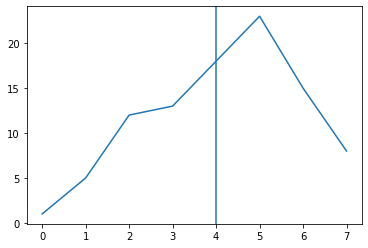

In [42]:
import matplotlib.pyplot as plt
plt.plot(weight_distribution[0], weight_distribution[1])
plt.axvline(x= expected_weight)
plt.show()

# The erasure model

In [150]:
def find_complexity_p(parameters, p):
    """
    Returns the log_2 of the bit complexity of our key exposure attack on Rainbow
    with eraruse probability p.
    """
    q,v,o1,o2 = parameters
    bit_complex = log(q, 2) ** 2 * 2**(o2 * p * log(q, 2)) * (o2**3 + (v + o1 + o2) ** 3)
    return log(bit_complex, 2)

def find_maximum_p(parameters, limit_complexity):
    """
    Returns the maximum errasure probability so that the bit complexity of our key exposure attack on Rainbow
    is smaller than 2^{limit_complexity}
    """
    list_p = []
    for p in range(0, 101):
        if find_complexity_p(parameters, p/100) < limit_complexity:
            list_p.append(p/100)
    return float(max(list_p))

In [151]:
#Rainbow parameters
# (q, v1, o1, o2)
RI_params = (16, 36, 32, 32)
RIII_params = (256, 68, 32, 48)
RV_params = (256, 96, 36, 64)

limit_complexities = [45, 60, 80]
for limit_complexity in limit_complexities:
    print(find_maximum_p(RI_params, limit_complexity))

0.16
0.28
0.43


In [152]:
#plots

#data for plot Rainbow_I
p_values = [k/100 for k in range(100)]
for p in p_values:
    print('{} {:.5}'.format(float(p), float(find_complexity_p(RI_params, p))))


0.0 23.978
0.01 25.258
0.02 26.538
0.03 27.818
0.04 29.098
0.05 30.378
0.06 31.658
0.07 32.938
0.08 34.218
0.09 35.498
0.1 36.778
0.11 38.058
0.12 39.338
0.13 40.618
0.14 41.898
0.15 43.178
0.16 44.458
0.17 45.738
0.18 47.018
0.19 48.298
0.2 49.578
0.21 50.858
0.22 52.138
0.23 53.418
0.24 54.698
0.25 55.978
0.26 57.258
0.27 58.538
0.28 59.818
0.29 61.098
0.3 62.378
0.31 63.658
0.32 64.938
0.33 66.218
0.34 67.498
0.35 68.778
0.36 70.058
0.37 71.338
0.38 72.618
0.39 73.898
0.4 75.178
0.41 76.458
0.42 77.738
0.43 79.018
0.44 80.298
0.45 81.578
0.46 82.858
0.47 84.138
0.48 85.418
0.49 86.698
0.5 87.978
0.51 89.258
0.52 90.538
0.53 91.818
0.54 93.098
0.55 94.378
0.56 95.658
0.57 96.938
0.58 98.218
0.59 99.498
0.6 100.78
0.61 102.06
0.62 103.34
0.63 104.62
0.64 105.9
0.65 107.18
0.66 108.46
0.67 109.74
0.68 111.02
0.69 112.3
0.7 113.58
0.71 114.86
0.72 116.14
0.73 117.42
0.74 118.7
0.75 119.98
0.76 121.26
0.77 122.54
0.78 123.82
0.79 125.1
0.8 126.38
0.81 127.66
0.82 128.94
0.83 130.22
0.84 

In [68]:
#data for plot Rainbow_V
p_values = [k/100 for k in range(100)][:30]
for p in p_values:
    print('{} {:.5}'.format(float(p), float(find_complexity_p(RV_params, p))))

0.0 28.894
0.01 34.014
0.02 39.134
0.03 44.254
0.04 49.374
0.05 54.494
0.06 59.614
0.07 64.734
0.08 69.854
0.09 74.974
0.1 80.094
0.11 85.214
0.12 90.334
0.13 95.454
0.14 100.57
0.15 105.69
0.16 110.81
0.17 115.93
0.18 121.05
0.19 126.17
0.2 131.29
0.21 136.41
0.22 141.53
0.23 146.65
0.24 151.77
0.25 156.89
0.26 162.01
0.27 167.13
0.28 172.25
0.29 177.37


### Experiments bit complexity errasure model (our attack)

In [6]:
#Each row of the matrix matrix_key represents a vector of the form  (S'_i, f_i^v)
# ones in the matrix represent erasured bits 
import numpy as np
def generate_erasure_s_fv_vector(parameters, p):
    """
    Returns a o1 x (o2 * v * (v+1) /2) matrix where every row represent an erasure vetor of the form (S'_i, f_i ^v),
    where S,_i denotes the i-th row the matrix S' and f_i^v a vector containing the v * (v + 1)/2 
    coefficients of the vinegar part of the i-th polynomial in the central map.
    """
    q,v,o1,o2 = parameters
    matrix_key = zero_matrix(GF(2), o1, (o2 + v*(v-1)/2) * ceil(log(q, 2)))
    for i in range(o1):
        for j in range(matrix_key.dimensions()[1]):
            matrix_key.add_to_entry(i,j,np.random.binomial(1, p))
            
    return matrix_key

In [2]:
#Example
parameters = (16, 5, 5,5)
matrix_key = generate_erasure_s_fv_vector(parameters, 0.6)
print(matrix_key)

[0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1]
[1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0]
[1 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1]
[0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1]
[1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0]


In [44]:
#In this part we denote by matrix_key the output of the function generate_erasure_s_fv_vector 

def nbits_to_enumerate_field_element(len_log_2_q_vector):
    """
    Input: The binary representation of  an element in Fq
    
    Output: The number of bits to enumerate of a given erasure vector with 
    binary representation len_log_2_q_vector. 
    """
    return list(len_log_2_q_vector).count(1)

def nbits_to_enumerate_per_entry_sorted(parameters, row):
    """
    Input: Rainbow parameters and a binary row represeting the binary representation of several elements in Fq
    
    Output: an increasing sorted list containing of the number of ones of all binary represention of the
    elements in row
    """
    q,v,o1,o2 = parameters
    enumerate_per_entry = []
    for i in range(0, len(row), ceil(log(q,2))):
        enumerate_per_entry.append(nbits_to_enumerate_field_element(row[i :i + ceil(log(q, 2))]))
    
    enumerate_per_entry.sort()

    return enumerate_per_entry

def nbits_to_enumerate_row(parameters, row):
    """
    Returns the number of bits we have to enumerate in the row 'row' so we can get to know o2 field elements Fq
    """
    q,v,o1,o2 = parameters
    return sum(nbits_to_enumerate_per_entry_sorted(parameters, row)[:o2])

def nbits_to_enumerate(parameters, matrix_key):
    """
    Return the minimum number of bits we have to enumerate to find o2 full field elements of any row of matrix_key
    """
    return min([nbits_to_enumerate_row(parameters, matrix_key[i]) for i in range(matrix_key.dimensions()[0])])


def find_complexity_nbits(parameters, min_nbits):
    """
    Input: min_nbits is  the minimum number of bits we have to enumerate to find o2 vectors in a row of matrix_key
    
    Output: Returns the log_2 of the bit complexity of our attack in the erasure model 
    """
    q,v,o1,o2 = parameters
    bit_complex = log(q, 2) ** 2 * 2**(min_nbits) * (o2**3 + (v + o1 + o2) ** 3)
    return log(bit_complex, 2)

def errasure_model_bit_complexity_one_shot(parameters, p):
    """
    Input: Rainbow parameters and an erasure probability p
    
    Output: The bit complexity of to recover a row of S' from a noisy matrix_key with the erasure probability p.
    """
    matrix_key = generate_erasure_s_fv_vector(parameters, p)
    nbits = nbits_to_enumerate(parameters, matrix_key)
    complx = find_complexity_nbits(parameters, nbits)
    return float(complx)

def errasure_model_bit_complexity_several_shots(parameters, p, nsamples=10):
    """
    Return a list of the output of several executions of the previous function for a given erasure probability p
    """
    L = []
    for _ in range(nsamples):
        complx_p = errasure_model_bit_complexity_one_shot(parameters, p)
        print(float(p), complx_p)
        L.append(complx_p)
    return L

def errasure_model_bit_complexity(parameters, p_values, nsamples=10):
    """
    Input: Rainbow parameters and an a list of erasure probabilities p_values
    
    Output: The average complexity of our erasure attack for every errasure probability p in p_values
    """
    averages = []
    for p in p_values:
        Lp  = errasure_model_bit_complexity_several_shots(parameters, p, nsamples)
        avg_p = float(sum(Lp)/len(Lp))
        averages.append([p, avg_p])
    return averages 

In [4]:
#Rainbow parameters
# (q, v1, o1, o2)
RI_params = (16, 36, 32, 32)
RIII_params = (256, 68, 32, 48)
RV_params = (256, 96, 36, 64)

In [5]:
#Data to create figure 3
parameters = RI_params
p_values = [k/100 for k in range(101)]
averages = errasure_model_bit_complexity(parameters, p_values, nsamples=10)

0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.0 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.01 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.02 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.03 23.978084774310684
0.04 23.978084774310684
0.04 23.978084774310684
0.

In [9]:
#Data to create figure 3
p_values = [0.99 + i * 0.001 for i in range(11)]
averages = errasure_model_bit_complexity(parameters, p_values, nsamples=10)

0.99 117.97808477431069
0.99 118.97808477431069
0.99 116.97808477431069
0.99 118.97808477431069
0.99 117.97808477431069
0.99 118.97808477431069
0.99 118.97808477431069
0.99 116.97808477431069
0.99 118.97808477431069
0.99 118.97808477431069
0.991 119.97808477431067
0.991 118.97808477431069
0.991 121.97808477431069
0.991 119.97808477431067
0.991 118.97808477431069
0.991 118.97808477431069
0.991 116.97808477431069
0.991 117.97808477431069
0.991 115.97808477431069
0.991 120.97808477431067
0.992 121.97808477431069
0.992 121.97808477431069
0.992 121.97808477431069
0.992 123.97808477431069
0.992 124.97808477431069
0.992 122.97808477431069
0.992 124.97808477431069
0.992 120.97808477431067
0.992 119.97808477431067
0.992 119.97808477431067
0.993 120.97808477431067
0.993 122.97808477431069
0.993 120.97808477431067
0.993 121.97808477431069
0.993 124.97808477431069
0.993 124.97808477431069
0.993 124.97808477431069
0.993 123.97808477431069
0.993 126.97808477431069
0.993 125.97808477431069
0.994 127.

In [10]:
for i in averages:
    print(float(i[0]), i[1])

0.99 118.3780847743107
0.991 119.07808477431067
0.992 122.3780847743107
0.993 123.87808477431068
0.994 127.67808477431068
0.995 129.87808477431068
0.996 134.97808477431067
0.997 137.57808477431067
0.998 141.07808477431067
0.999 145.47808477431067
1.0 151.97808477431067


In [157]:
parameters = RV_params
p_values = [k/100 for k in range(101)][37:]
averages_V = errasure_model_bit_complexity(parameters, p_values, nsamples=10)

0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.37 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.38 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.39 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.4 28.8935029972715
0.41 28.8935029972715
0.41 28.8935029972715
0.41 28.8935029972715
0.41 28.8935029972715
0.41 28.8935029972715
0.41 28.893502997271

In [158]:
for i in averages_V:
    print(float(i[0]), i[1])

0.37 28.893502997271504
0.38 28.893502997271504
0.39 28.893502997271504
0.4 28.893502997271504
0.41 28.893502997271504
0.42 28.893502997271504
0.43 29.393502997271504
0.44 35.393502997271504
0.45 42.5935029972715
0.46 49.393502997271504
0.47 53.49350299727151
0.48 56.49350299727151
0.49 61.79350299727152
0.5 64.89350299727151
0.51 67.19350299727151
0.52 70.89350299727151
0.53 74.09350299727151
0.54 76.39350299727151
0.55 77.59350299727151
0.56 80.19350299727151
0.57 82.59350299727151
0.58 85.29350299727152
0.59 89.69350299727151
0.6 100.49350299727152
0.61 107.7935029972715
0.62 114.4935029972715
0.63 119.9935029972715
0.64 125.4935029972715
0.65 129.09350299727151
0.66 132.9935029972715
0.67 136.3935029972715
0.68 139.59350299727151
0.69 142.4935029972715
0.7 147.9935029972715
0.71 154.1935029972715
0.72 165.9935029972715
0.73 173.2935029972715
0.74 180.7935029972715
0.75 189.2935029972715
0.76 194.7935029972715
0.77 199.6935029972715
0.78 201.4935029972715
0.79 205.29350299727147
0.8

In [12]:
from math import log2, ceil
def element_fliping_probability(q, p): return 1 - (1 - p) ** log2(q)

def expected_weight(q, v1, o2, p):
    tildep = element_fliping_probability(q, p)
    return ceil(tildep * (v1 + o2))

def expected_binary_weight(q, r, o2, p):
    """
    Expected weight of (e_1,..., e_(v1 + o2)) as a binary vector og lenght log2(q) * (v1 + v2)
    """ 
    return ceil(log(q, 2) * (r + o2) * p)

In [13]:
def number_of_permutations(q, v1, o2, p):
    w = expected_weight(q, v1, o2, p)
    if w <= v1:
        return ceil(binomial(v1 + o2, w)/ binomial(v1, w))
    else:
        return 0
    
def number_of_permutations(q, v1, o2, p):
    w = expected_weight(q, v1, o2, p)
    if w <= v1:
        return ceil(binomial(v1 + o2, w)/ binomial(v1, w))
    else:
        return 0

In [21]:
def cold_boot_bit_complexity(q, r, v1, o2, p):
    num_per = number_of_permutations(q, v1, o2, p)
    return max(binomial(ceil(log(q, 2) * (v1 + o2)), w) / (v1 ** 3), 1)
    

In [22]:
range_p = [i*0.01 for i in range(30)]

In [23]:
(q, v1, o1, o2) = RI_params
y_I_permutations = [number_of_permutations(q, v1, o2, p) for p in range_p]
y_I_enumerations = [number_of_enumerations(q, v1, o2, p) for p in range_p]

(q, v1, o1, o2) = RIII_params
y_III_permutations = [number_of_permutations(q, v1, o2, p) for p in range_p]
y_III_enumerations = [number_of_enumerations(q, v1, o2, p) for p in range_p]

(q, v1, o1, o2) = RV_params
y_V_permutations = [number_of_permutations(q, v1, o2, p) for p in range_p]
y_V_enumerations = [number_of_enumerations(q, v1, o2, p) for p in range_p]

In [24]:
#print data
for i in range(18):
    print('{:.2f} {:.4f} {:.4f}'.format(range_p[i].numerical_approx(), log2(y_I_permutations[i]), log2(y_I_enumerations[i])))


0.00 0.0000 0.0000
0.01 3.0000 0.0000
0.02 5.8329 6.1517
0.03 7.9366 12.2232
0.04 11.3174 23.4430
0.05 13.7287 28.6910
0.06 16.2819 33.7408
0.07 20.4205 38.6153
0.08 23.4217 47.9063
0.09 26.6544 52.3492
0.10 30.1620 56.6711
0.11 34.0033 64.9849
0.12 38.2613 68.9906
0.13 43.0613 72.9031
0.14 45.7242 76.7275
0.15 51.7817 84.1293
0.16 59.4135 87.7143
0.17 64.4579 91.2264


In [25]:
#print data Raibow III
for i in range(11):
    print('{:.2f} {:.4f} {:.4f}'.format(range_p[i].numerical_approx(), log2(y_III_permutations[i]), log2(y_III_enumerations[i])))



0.00 0.0000 0.0000
0.01 7.2761 16.5752
0.02 15.4299 45.2586
0.03 23.6252 71.0949
0.04 31.7386 95.0276
0.05 41.0087 117.5224
0.06 50.1894 138.8588
0.07 60.9685 154.2153
0.08 71.7379 173.9408
0.09 85.1415 192.9059
0.10 104.1492 211.1935


In [26]:
#print data Raibow V
for i in range(11):
    print('{:.2f} {:.4f} {:.4f}'.format(range_p[i].numerical_approx(), log2(y_V_permutations[i]), log2(y_V_enumerations[i])))



0.00 0.0000 0.0000
0.01 10.0861 32.6679
0.02 19.6017 68.4737
0.03 30.2555 101.0100
0.04 41.1972 131.2979
0.05 52.3718 159.8645
0.06 65.2182 187.0333
0.07 78.5637 213.0235
0.08 92.3709 237.9934
0.09 109.2371 266.7777
0.10 131.7571 289.8894


### Experiment errasure model: enumerating missing the bits in a row of S' 

In [19]:
def generate_erasured_S_prime(parameters, p):
    q,v,o1,o2 = parameters
    erasured_S_prime = zero_matrix(GF(2), o1, o2 * ceil(log(q, 2)))
    for i in range(o1):
        for j in range(erasured_S_prime.dimensions()[1]):
            erasured_S_prime.add_to_entry(i,j,np.random.binomial(1, p))
            
    return erasured_S_prime

def nbits_to_enumerate_S_prime(erasured_S_prime):
    nbits_lits =[]
    for i in range(erasured_S_prime.dimensions()[0]):
        nbits_lits.append(list(erasured_S_prime[i]).count(1))
    
    return min(nbits_lits)


def find_complexity_erasure_naive_nbits(parameters, nbits):
    q,v,o1,o2 = parameters
    bit_complex = log(q, 2) ** 2 * 2**(nbits) * (v + o1 + o2) ** 3
    return log(bit_complex, 2)

def complexity_erasure_naive_one_shot(parameters, p):
    erasured_S_prime = generate_erasured_S_prime(parameters, p)
    nbits = nbits_to_enumerate_S_prime(erasured_S_prime)
    complx = find_complexity_erasure_naive_nbits(parameters, nbits)
    return float(complx)

def complexity_erasure_naive_one_shot_several_shots(parameters, p, nsamples=10):
    L = []
    for _ in range(nsamples):
        complx_p = complexity_erasure_naive_one_shot(parameters, p)
        print(float(p), complx_p)
        L.append(complx_p)
    return L

def errasure_model_bit_complexity_naive(parameters, p_values, nsamples=10):
    averages = []
    for p in p_values:
        Lp  = complexity_erasure_naive_one_shot_several_shots(parameters, p, nsamples)
        avg_p = float(sum(Lp)/len(Lp))
        averages.append([p, avg_p])
    return averages 

In [20]:
#Rainbow parameters
# (q, v1, o1, o2)
RI_params = (16, 36, 32, 32)
RIII_params = (256, 68, 32, 48)
RV_params = (256, 96, 36, 64)



In [21]:
parameters = RI_params
p_values = [k/100 for k in range(101)]
averages = errasure_model_bit_complexity_naive(parameters, p_values, nsamples=10)

0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.0 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.01 23.931568569324174
0.02 23.931568569324174
0.02 23.931568569324174
0.02 23.931568569324174
0.02 24.931568569324178
0.02 23.931568569324174
0.02 23.931568569324174
0.02 24.931568569324178
0.02 24.931568569324178
0.02 24.931568569324178
0.02 23.931568569324174
0.03 23.931568569324174
0.03 23.931568569324174
0.03 23.931568569324174
0.03 23.931568569324174
0.03 24.931568569324178
0.03 24.931568569324178
0.03 24.931568569324178
0.03 25.931568569324174
0.03 25.931568569324174
0.03 23.931568569324174
0.04 25.931568569324174
0.04 24.931568569324178
0.

In [22]:
for i in averages:
    print(float(i[0]), i[1])

0.0 23.931568569324178
0.01 23.931568569324178
0.02 24.33156856932418
0.03 24.63156856932418
0.04 25.33156856932418
0.05 25.83156856932418
0.06 27.131568569324173
0.07 27.331568569324173
0.08 28.83156856932417
0.09 29.431568569324174
0.1 29.931568569324174
0.11 31.531568569324172
0.12 32.13156856932417
0.13 32.93156856932417
0.14 34.23156856932416
0.15 34.83156856932417
0.16 37.631568569324166
0.17 37.43156856932417
0.18 38.13156856932417
0.19 40.43156856932417
0.2 40.63156856932416
0.21 41.33156856932417
0.22 42.43156856932417
0.23 43.531568569324165
0.24 44.031568569324165
0.25 46.531568569324165
0.26 46.73156856932417
0.27 48.031568569324165
0.28 49.93156856932417
0.29 52.23156856932417
0.3 52.131568569324166
0.31 52.33156856932417
0.32 53.93156856932417
0.33 54.531568569324165
0.34 58.03156856932418
0.35 57.331568569324176
0.36 60.531568569324165
0.37 61.03156856932418
0.38 63.131568569324166
0.39 62.23156856932418
0.4 61.63156856932418
0.41 63.93156856932418
0.42 67.83156856932418

In [23]:
parameters = RV_params
p_values = [k/100 for k in range(101)]
averages_V_naive = errasure_model_bit_complexity_naive(parameters, p_values, nsamples=10)

0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.0 28.844129532345622
0.01 28.844129532345622
0.01 29.844129532345626
0.01 30.844129532345622
0.01 29.844129532345626
0.01 30.844129532345622
0.01 29.844129532345626
0.01 31.844129532345626
0.01 30.844129532345622
0.01 29.844129532345626
0.01 30.844129532345622
0.02 33.844129532345626
0.02 31.844129532345626
0.02 34.844129532345626
0.02 33.844129532345626
0.02 33.844129532345626
0.02 34.844129532345626
0.02 32.84412953234562
0.02 33.844129532345626
0.02 33.844129532345626
0.02 30.844129532345622
0.03 32.84412953234562
0.03 34.844129532345626
0.03 35.844129532345626
0.03 36.844129532345626
0.03 37.844129532345626
0.03 37.844129532345626
0.03 34.844129532345626
0.03 35.844129532345626
0.03 36.844129532345626
0.03 38.844129532345626
0.04 42.844129532345626
0.04 41.844129532345626
0.04

In [24]:
for i in averages_V_naive:
    print(float(i[0]), i[1])

0.0 28.844129532345626
0.01 30.344129532345626
0.02 33.44412953234563
0.03 36.24412953234562
0.04 41.94412953234563
0.05 45.54412953234562
0.06 47.94412953234563
0.07 53.144129532345616
0.08 57.04412953234562
0.09 62.74412953234562
0.1 66.84412953234562
0.11 71.04412953234562
0.12 75.34412953234562
0.13 80.14412953234563
0.14 83.84412953234562
0.15 87.84412953234562
0.16 92.44412953234561
0.17 96.44412953234561
0.18 102.44412953234561
0.19 105.64412953234562
0.2 114.14412953234562
0.21 116.34412953234559
0.22 121.04412953234562
0.23 127.24412953234564
0.24 132.6441295323456
0.25 137.3441295323456
0.26 142.8441295323456
0.27 145.0441295323456
0.28 149.2441295323456
0.29 154.6441295323456
0.3 158.44412953234558
0.31 164.94412953234558
0.32 171.8441295323456
0.33 176.1441295323456
0.34 180.5441295323456
0.35 184.94412953234558
0.36 191.1441295323456
0.37 194.8441295323456
0.38 198.84412953234565
0.39 205.54412953234564
0.4 212.5441295323456
0.41 217.84412953234565
0.42 219.84412953234556
